In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline, interp1d

In [3]:
# Example synthetic data (replace with your data)
maturities = np.array([0.1, 0.5, 1.0])  # Time to expiry (years)
strikes = np.array([80, 90, 100, 110, 120])  # Strike prices
implied_vols = np.array([  # Implied volatilities (matrix: maturities x strikes)
    [0.25, 0.23, 0.20, 0.22, 0.25],
    [0.23, 0.21, 0.19, 0.21, 0.24],
    [0.22, 0.20, 0.18, 0.20, 0.23]
])

In [4]:
def svi_total_variance(k, params):
    a, b, rho, m, sigma = params
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def svi_error(params, k, total_var):
    return np.sum((svi_total_variance(k, params) - total_var)**2)

In [5]:
def fit_svi_slice(k_values, total_var_values, initial_guess):
    # Constrained optimization to avoid arbitrage
    bounds = [
        (-np.inf, np.inf),  # a
        (0, np.inf),        # b > 0
        (-1, 1),           # rho in [-1, 1]
        (-np.inf, np.inf), # m
        (0, np.inf)         # sigma > 0
    ]
    result = minimize(svi_error, initial_guess, args=(k_values, total_var_values), 
                      bounds=bounds, method='L-BFGS-B')
    return result.x

# Example: Fit SVI for one maturity
T = 0.5  # Choose a maturity
forward_price = 100  # Assume spot price S=100
k = np.log(strikes / forward_price)
total_var = implied_vols[1]**2 * T  # Total variance = σ²T

initial_guess = [0.1, 0.1, 0.1, 0.1, 0.1]
params = fit_svi_slice(k, total_var, initial_guess)
print("Fitted SVI parameters:", params)

Fitted SVI parameters: [ 0.01015388  0.07688961  0.12086934 -0.00136466  0.11071537]


In [6]:
# Fit SVI parameters for all maturities
svi_params = []
for i, T in enumerate(maturities):
    total_var = implied_vols[i]**2 * T
    params = fit_svi_slice(np.log(strikes / forward_price), total_var, initial_guess)
    svi_params.append(params)

svi_params = np.array(svi_params)

# Interpolate parameters across maturities using cubic splines
param_names = ['a', 'b', 'rho', 'm', 'sigma']
interpolated_params = {}
for i in range(5):
    interpolator = CubicSpline(maturities, svi_params[:, i])
    interpolated_params[param_names[i]] = interpolator

In [7]:
def implied_volatility(T, K, forward_price, interpolated_params):
    k = np.log(K / forward_price)
    a = interpolated_params['a'](T)
    b = interpolated_params['b'](T)
    rho = interpolated_params['rho'](T)
    m = interpolated_params['m'](T)
    sigma = interpolated_params['sigma'](T)
    total_var = a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))
    return np.sqrt(total_var / T)  # Convert back to volatility

# Example: Compute IV for T=0.3, K=105
T_test = 0.3
K_test = 105
iv = implied_volatility(T_test, K_test, forward_price, interpolated_params)
print(f"IV at T={T_test}, K={K_test}: {iv:.4f}")

IV at T=0.3, K=105: 0.1967


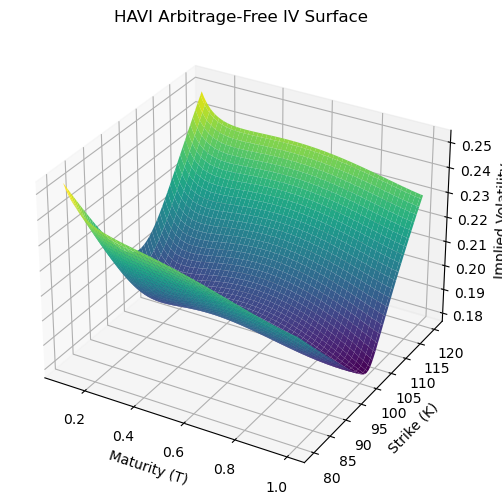

In [8]:
T_grid = np.linspace(maturities.min(), maturities.max(), 100)
K_grid = np.linspace(strikes.min(), strikes.max(), 100)
T_mesh, K_mesh = np.meshgrid(T_grid, K_grid)

iv_surface = np.zeros_like(T_mesh)
for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        iv_surface[i, j] = implied_volatility(T_mesh[i, j], K_mesh[i, j], forward_price, interpolated_params)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(T_mesh, K_mesh, iv_surface, cmap='viridis')
ax.set_xlabel('Maturity (T)')
ax.set_ylabel('Strike (K)')
ax.set_zlabel('Implied Volatility')
plt.title('HAVI Arbitrage-Free IV Surface')
plt.show()

Calibrated SVI parameters: 0.004392703093679729 0.13163970200798997 0.00014443085984474212 -0.0010129121942042344 0.06977436950673639


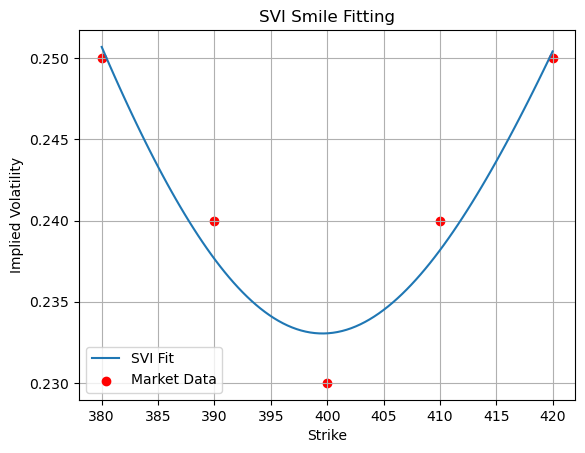

In [9]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Assume we already pulled:
# strikes (K), implied volatilities (iv), spot (S0), forward (F)

def svi_total_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

def svi_loss(params, k, market_w):
    a, b, rho, m, sigma = params
    model_w = svi_total_variance(k, a, b, rho, m, sigma)
    return np.sum((model_w - market_w)**2)

def calibrate_svi(strikes, implied_vols, forward, T):
    k = np.log(strikes / forward)
    w_market = (implied_vols ** 2) * T  # total variance
    
    # initial guess
    init_params = [0.01, 0.1, 0.0, 0.0, 0.1]
    
    bounds = [
        (-1, 1),  # a
        (0.0001, 10),  # b
        (-0.999, 0.999),  # rho
        (-1.0, 1.0),  # m
        (0.001, 1.0)  # sigma
    ]
    
    result = opt.minimize(svi_loss, init_params, args=(k, w_market), method='L-BFGS-B', bounds=bounds)
    
    a, b, rho, m, sigma = result.x
    print("Calibrated SVI parameters:", a, b, rho, m, sigma)
    
    return lambda k: np.sqrt(svi_total_variance(k, a, b, rho, m, sigma) / T)

# Example Fake Data
strikes = np.array([380, 390, 400, 410, 420])
implied_vols = np.array([0.25, 0.24, 0.23, 0.24, 0.25])  # 25%, 24%, etc.
forward = 400
T = 0.25  # 3 months to expiry

# Calibrate
svi_iv_function = calibrate_svi(strikes, implied_vols, forward, T)

# Plot
k_plot = np.linspace(np.log(380/400), np.log(420/400), 100)
iv_plot = svi_iv_function(k_plot)

plt.plot(np.exp(k_plot)*forward, iv_plot, label='SVI Fit')
plt.scatter(strikes, implied_vols, color='red', label='Market Data')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()
plt.title('SVI Smile Fitting')
plt.grid(True)
plt.show()

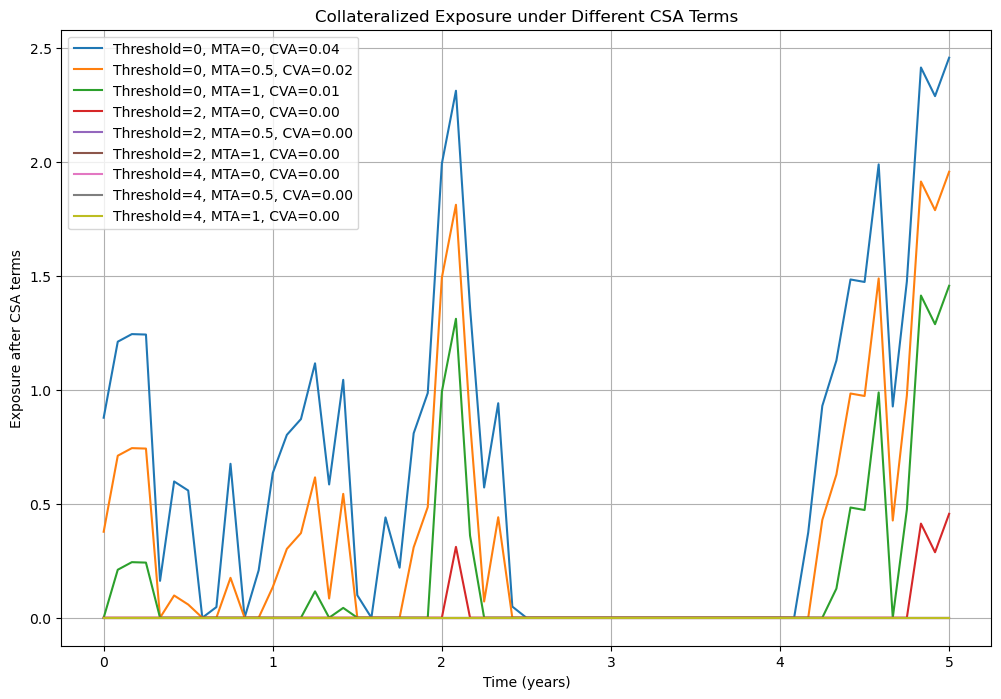


CVA Values:
Threshold = 0, MTA = 0 => CVA = 0.04
Threshold = 0, MTA = 0.5 => CVA = 0.02
Threshold = 0, MTA = 1 => CVA = 0.01
Threshold = 2, MTA = 0 => CVA = 0.00
Threshold = 2, MTA = 0.5 => CVA = 0.00
Threshold = 2, MTA = 1 => CVA = 0.00
Threshold = 4, MTA = 0 => CVA = 0.00
Threshold = 4, MTA = 0.5 => CVA = 0.00
Threshold = 4, MTA = 1 => CVA = 0.00


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
T = 5  # years
steps_per_year = 12
steps = T * steps_per_year

dt = 1 / steps_per_year

recovery_rate = 0.4
hazard_rate = 0.02  # 2% flat hazard rate

default_prob = 1 - np.exp(-hazard_rate * dt)

def simulate_exposure_path():
    """Simulate a random exposure path."""
    times = np.linspace(0, T, steps + 1)
    exposure = np.maximum(0, np.cumsum(np.random.normal(0, 0.5, size=steps + 1)))
    return times, exposure

def compute_cva(times, exposure, threshold=0.0, mta=0.0):
    """Compute CVA given exposure path and CSA terms."""
    collateralized_exposure = np.maximum(exposure - threshold - mta, 0)
    cva = 0
    for i in range(1, len(times)):
        delta_pd = default_prob
        discounted_exposure = collateralized_exposure[i]  # Assuming flat discounting for simplicity
        cva += (1 - recovery_rate) * discounted_exposure * delta_pd
    return cva

# --- Simulate ---
times, exposure = simulate_exposure_path()

thresholds = [0, 2, 4]
mtas = [0, 0.5, 1]

plt.figure(figsize=(12, 8))
for threshold in thresholds:
    for mta in mtas:
        cva = compute_cva(times, exposure, threshold, mta)
        plt.plot(times, np.maximum(exposure - threshold - mta, 0), label=f'Threshold={threshold}, MTA={mta}, CVA={cva:.2f}')

plt.title('Collateralized Exposure under Different CSA Terms')
plt.xlabel('Time (years)')
plt.ylabel('Exposure after CSA terms')
plt.legend()
plt.grid()
plt.show()

# Print CVA summary
print("\nCVA Values:")
for threshold in thresholds:
    for mta in mtas:
        cva = compute_cva(times, exposure, threshold, mta)
        print(f"Threshold = {threshold}, MTA = {mta} => CVA = {cva:.2f}")